### 1. Load data

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import utils

dataset, info = tfds.load('mnist', as_supervised=True, split='train', with_info=True)

In [ ]:
info

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

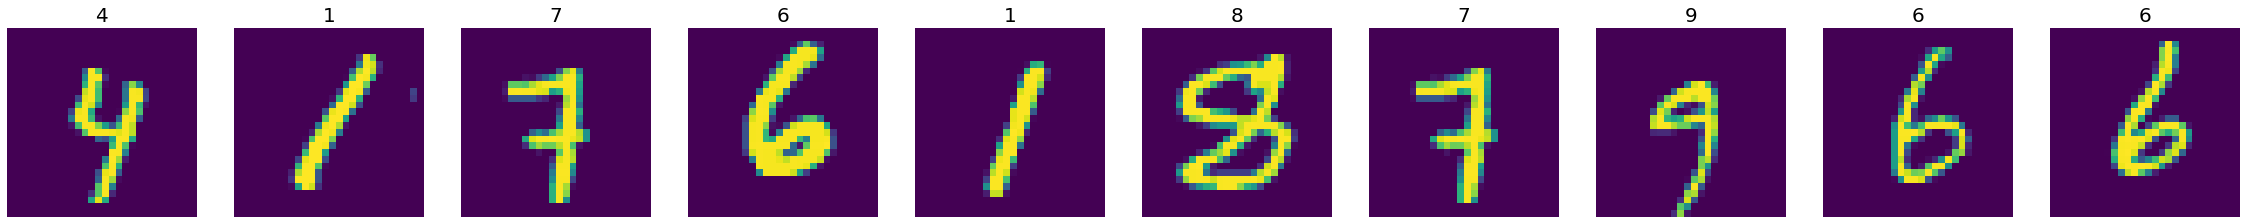

In [ ]:
images, labels = utils.dataset_to_numpy(dataset)

# plot raw images
utils.plot_random_images(images, labels, (28, 28))

The digits in the image are mostly centered, but in reality, they could appear in various locations. To reflect this in the training set, the images will be placed on a 75 x 75 canvas at random locations.

In [ ]:
BATCH_SIZE = 64

dataset = dataset.map(place_images_on_canvas)
dataset = dataset.shuffle(60000)
dataset = dataset.repeat()
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

### 2. Training and evaluation

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

inputs = Input(shape=(75, 75, 1))

x = tf.keras.layers.Conv2D(16, 3, activation='relu')(inputs)
x = tf.keras.layers.AveragePooling2D(2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.AveragePooling2D(2)(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.AveragePooling2D(2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

scores = tf.keras.layers.Dense(10, activation='softmax', name='classifier')(x)
bboxes = tf.keras.layers.Dense(4, name='bounding_box')(x)

model = Model(inputs=inputs, outputs=[scores, bboxes])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 73, 73, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 36, 36, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 34, 34, 32)   4640        average_pooling2d[0][0]          
______________________________________________________________________________________________

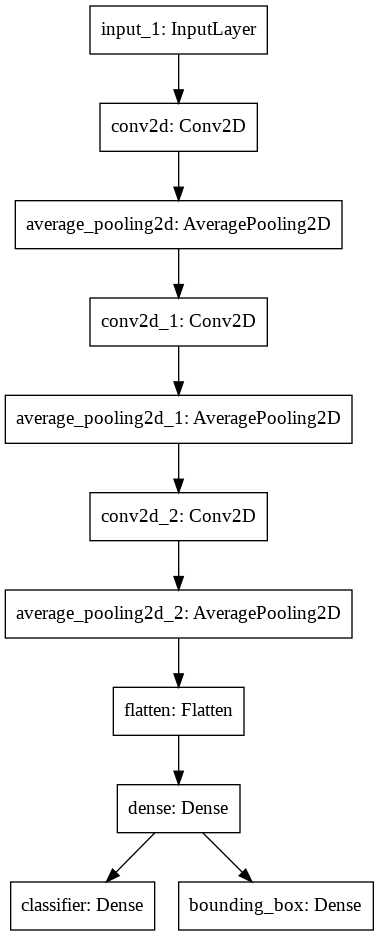

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(loss={'classifier': 'categorical_crossentropy',
                    'bounding_box': 'mse'},
              metrics={'classifier': 'acc',
                       'bounding_box': 'mse'},
              optimizer='SGD')

history = model.fit(dataset, epochs=10, steps_per_epoch=60000/BATCH_SIZE)

Epoch 1/10
937/937 [==============================] - 56s 15ms/step - loss: 2.3339 - classifier_loss: 2.3022 - bounding_box_loss: 0.0317 - classifier_acc: 0.1116 - bounding_box_mse: 0.0317
Epoch 2/10
937/937 [==============================] - 14s 15ms/step - loss: 2.2979 - classifier_loss: 2.2924 - bounding_box_loss: 0.0055 - classifier_acc: 0.1512 - bounding_box_mse: 0.0055
Epoch 3/10
937/937 [==============================] - 14s 15ms/step - loss: 2.2202 - classifier_loss: 2.2166 - bounding_box_loss: 0.0036 - classifier_acc: 0.1983 - bounding_box_mse: 0.0036
Epoch 4/10
937/937 [==============================] - 14s 15ms/step - loss: 2.0698 - classifier_loss: 2.0649 - bounding_box_loss: 0.0049 - classifier_acc: 0.2368 - bounding_box_mse: 0.0049
Epoch 5/10
937/937 [==============================] - 14s 14ms/step - loss: 2.0220 - classifier_loss: 2.0164 - bounding_box_loss: 0.0056 - classifier_acc: 0.2614 - bounding_box_mse: 0.0056
Epoch 6/10
937/937 [==============================] - 1

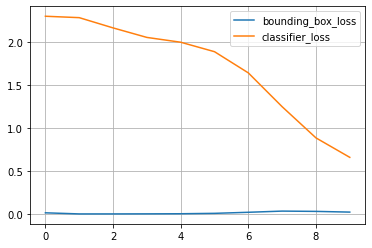

In [ ]:
bbox_loss = history.history['bounding_box_loss']
cls_loss = history.history['classifier_loss']

epochs = range(len(bbox_loss))

plt.plot(epochs, bbox_loss, label='bounding_box_loss')
plt.plot(epochs, cls_loss, label='classifier_loss')
plt.grid(True)
plt.legend()
plt.show()